# Faster than the clock algorithms

Faster than the clock algorithms are useful in cases when the acceptance rate of the standard Monte Carlo is low. An example of this is the Ising model at low temperatures, when we are disregarding most of the moves. The idea of the faster than the clock algorithms is to speed up the simulation by calculating the probability distribution of the number of moves that will be required in order to change the state of the system. Then, only accepted moves need to be evaluated during the simulation. One just has to properly generate the times between two of these accepted moves.

## Random depositions

Let's consider the problem of random depositions in one dimension. Consider the line of length $L$ on which we are randomly depositing  pins of width $2 \times \sigma$ on the interval $[\sigma,L-\sigma]$ which cannot overlap. At time $t=1$ we deposit the first pin and in succesive time steps we try to deposite further pins. We make the deposition if the move is allowed, otherwise we choose a new position etc. The process halts when no further pins can be deposited.

<br>
<table><tr style="background-color: white;">
<td> <img src="https://gist.github.com/mferrero/ae328ab0e3a0d3d7181a007daf5a373a/raw/clothes_pins_many.png" width=500 height=150 /> </td>
<td> <img src="https://gist.github.com/mferrero/ae328ab0e3a0d3d7181a007daf5a373a/raw/clothes_pins_single.png" width=200 height=150 /> </td>
</tr></table>
<br>

In the following, we will write two Monte Carlo algorithms to simulate random depositions, a direct real-time implementation and a faster than the clock implementation. Results will be compared with the analytical solution.

We first import the necessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Real time algorithm

Write the random depositions algorithm in real time, which outputs the times at which the depositions are made.
You can use pins with $\sigma = 1$. Start with $L = 100$ and increase to $L = 10000$ to see how the
simulation time changes.

Hint: It is a good idea to encode the positions of the pins in an *ordered* list. You can then use bisection to quickly find where a new pin has to be inserted. This example shows how to use the `bisect` function
```python
pins = [1, 4, 6, 7, 10, 16]
ind = bisect.bisect(pins, 9) # find where 9 would go
pins.insert(ind, 9) # insert 9 in the right place
print(pins)
```

In [3]:
def compute_space_left_length(space_left):
    length = 0
    for interval in space_left:
        length += interval[1] - interval[0]
    return length

def is_in_subset(pin_interval, space_left):
    for interval_index, interval in enumerate(space_left):
        if pin_interval[0] >= interval[0] and pin_interval[1] <= interval[1]:
            return True, interval_index
    return False, -1

In [4]:
def real_time_pins(sigma, total_length):
    
    deposition_times = []
    time = 0
    space_left = [[0, total_length]]
    space_left_length = total_length
    
    while space_left_length > 1e-10:
        
        pin_position = np.random.random() * total_length
        is_valid, interval_index = is_in_subset([pin_position - sigma, pin_position + sigma], space_left)
        
        if is_valid:
            deposition_times.append(time)
            old_interval = space_left.pop(interval_index)
            space_left_length -= 2 * sigma
            
            interval_below_length = pin_position - sigma - old_interval[0]
            interval_above_length = old_interval[1] - pin_position - sigma
            
            if interval_below_length >= 2 * sigma:
                space_left.append([old_interval[0], pin_position - sigma])
            else:
                space_left_length -= interval_below_length
            
            if interval_above_length >= 2 * sigma:
                space_left.append([pin_position + sigma, old_interval[1]])
            else:
                space_left_length -= interval_above_length
                
        time += 1
    
    return deposition_times

In [5]:
for _ in range(10):
    l = real_time_pins(1, 100)
    print(len(l), l[-1])

37 2298
35 198
39 1851
38 535
38 1906
38 5344
37 1441
37 360
34 535
36 3952


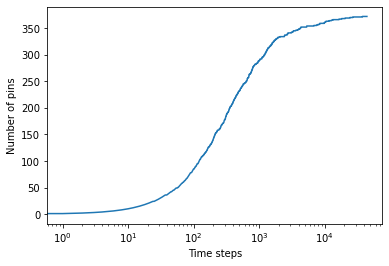

In [6]:
insertion_times = real_time_pins(1, 1000)
pin_number = []
for k in range(len(insertion_times) - 1):
    pin_number += (insertion_times[k + 1] - insertion_times[k]) * [k]
plt.plot(pin_number)
plt.xscale("log")
plt.xlabel("Time steps")
plt.ylabel("Number of pins")
print()

## Faster than the clock algorithm

As you must have seen, the real-time implementation of the algorithm can become very slow. Indeed,
the probability to place the pins at the right places when there is not so much space left becomes
very small. As a result, the simulation times can become very long. We will now see how this can
be avoided by implementing a faster than the clock algorithm. Here are the steps:

- Given a certain configuration of pins, make a list of all the intervals where new pins can
  be inserted.
  
- From the cumulative length of all these intervals, you can easily deduce the probability that the
  next trial insertion will be accepted. You then also know the probability $p_r$ that this trial
  will be rejected.

- The distribution of the number of steps $t$ until a proposal is accepted is given by

  $$
  \pi(t) = p_r^{t-1} (1 - p_r)
  $$
  
  This distribution can be sampled from a uniform random variable $\xi \in [0,1]$ with
  
  $$
  t = 1 + \left\lfloor \frac{\log(\xi)}{\log(p_r)} \right\rfloor
  $$

  With the knowledge of $p_r$ you can generate a faster than the clock time until the next
  accepted proposal.
  
- Produce a new configuration of pins by randomly choosing a valid position for the new pin.
  Be careful to pick this position uniformly across all valid intervals that you have found above.
  
- Keep track of the times when pins were inserted.

Hint: It is a good idea to construct the list of intervals by specifying both their length and the position on the line where they start. This will be useful to more easily find the place where the next pin will be inserted.

In [7]:
def find_position_and_interval_index(pin_relative_position, space_left):
    offset = pin_relative_position
    for index, interval in enumerate(space_left):
        if offset - (interval[1] - interval[0]) < 0:
            return offset + interval[0], index
        else:
            offset -= interval[1] - interval[0]
    raise Exception("Hello there")


# Here space_left is not the unoccupied space left, but the space where the center of a pin can be put

def faster_than_the_clock(sigma, total_length):
    
    deposition_times = []
    time = 0
    space_left = [[sigma, total_length - sigma]]
    space_left_length = total_length - 2 * sigma
    
    while space_left_length > 1e-10:
        
        time += np.random.geometric(space_left_length / total_length)
        deposition_times.append(time)
        
        pin_relative_position = np.random.random() * space_left_length
        pin_position, interval_index = find_position_and_interval_index(pin_relative_position, space_left)
        
        old_interval = space_left.pop(interval_index)

        interval_below_length = pin_position - 2*sigma - old_interval[0]
        interval_above_length = old_interval[1] - pin_position - 2*sigma

        if interval_below_length > 0:
            space_left.append([old_interval[0], pin_position - 2*sigma])

        if interval_above_length > 0:
            space_left.append([pin_position + 2*sigma, old_interval[1]])
        
        space_left_length = compute_space_left_length(space_left)
        
    return deposition_times

In [9]:
for _ in range(10):
    l = real_time_pins(1, 100)
    print(len(l), l[-1])
    
print()
for _ in range(10):
    l = faster_than_the_clock(1, 100)
    print(len(l), l[-1])

37 1451
39 738
36 1513
36 636
36 2884
37 544
39 4074
36 524
35 2472
36 648

38 5379
39 526
38 12507
37 8428
38 13890
37 1517
38 1504
35 763
37 289
37 1698


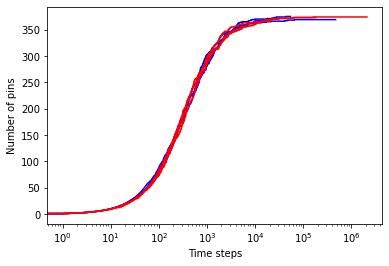

In [10]:
for _ in range(3):
    insertion_times = real_time_pins(1, 1000)
    pin_number = []
    for k in range(len(insertion_times) - 1):
        pin_number += (insertion_times[k + 1] - insertion_times[k]) * [k]
    plt.plot(pin_number, 'b')

for _ in range(3):
    insertion_times = faster_than_the_clock(1, 1000)
    pin_number = []
    for k in range(len(insertion_times) - 1):
        pin_number += (insertion_times[k + 1] - insertion_times[k]) * [k]
    plt.plot(pin_number, 'r')

    
plt.xscale("log")
plt.xlabel("Time steps")
plt.ylabel("Number of pins")
print()

## Comparison with analytical solution

It can be shown that the distribution of the density of pins as a function of
time is given by

$$
\rho(T) = \int_0^T  du\;\exp\left\{-2\int_{0}^u\frac{dv}{v}(1-e^{-v})\right\}
$$

where $T = 2\sigma t/L$ is a renormalized simulation time. Check if the faster than
the clock algorithm has produced densities in time that are compatible with this
formula. You can use this code to produce the analytical data:

```python
from scipy.integrate import quad

F = lambda u: quad(lambda v: (1 - np.exp(-v)) / v, 0, u)[0]
analytic = lambda T: quad(lambda u: np.exp(-2 * F(u)), 0, T)[0]
x_data = np.logspace(-4, 4, 50)
y_data = np.vectorize(analytic)(x_data)
```

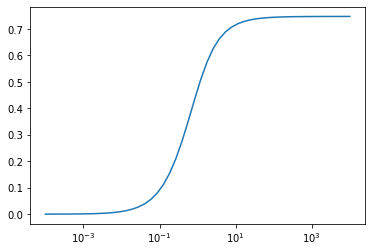

In [12]:
from scipy.integrate import quad

F = lambda u: quad(lambda v: (1 - np.exp(-v)) / v, 0, u)[0]
analytic = lambda T: quad(lambda u: np.exp(-2 * F(u)), 0, T)[0]
x_data = np.logspace(-4, 4, 50)
y_data = np.vectorize(analytic)(x_data)

plt.plot(x_data, y_data)
plt.xscale("log")

## References

* Rényi, A. "On a One-Dimensional Problem Concerning Random Space-Filling." Publ. Math. Inst. Hung. Acad. Sci. 3, 109-127, 1958 
* Y. Pomeau, Some asymptotic estimates in the random parking problem, J. Phys. A: Math. Gen. 13 L193 (1980)
* V. Privman, J.-S. Wang, and P. Nielaba, Continuum limit in random sequential adsorption, Phys. Rev. B 43 3366 (1991)